In [1]:
!pip install yfinance deap numpy pandas matplotlib --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 4.5 MB/s eta 0:00:00


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import random


[*********************100%***********************]  5 of 5 completed


Asignación óptima:
AAPL: 19.43%
META: 8.60%
MSFT: 39.37%
SPY: 30.61%
SSO: 2.00%

Retorno esperado anual: 25.00%
Desviación estándar anual: 26.72%


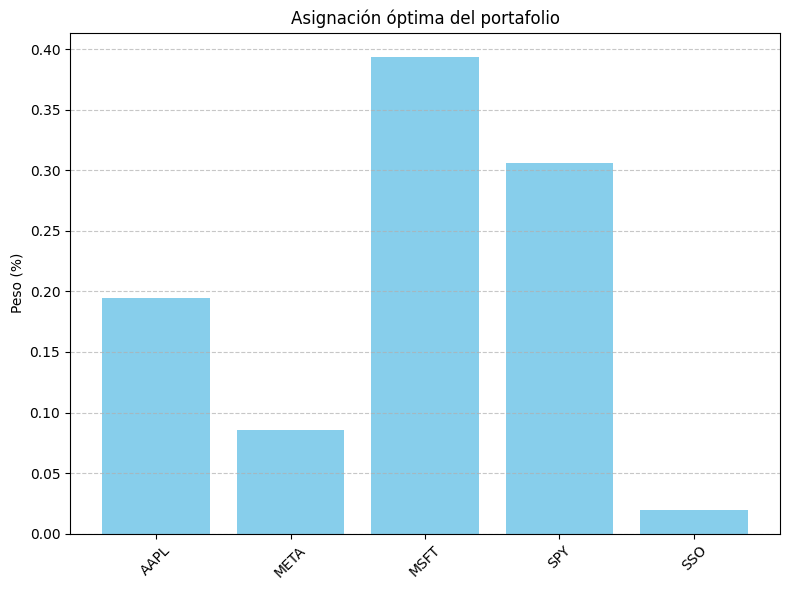

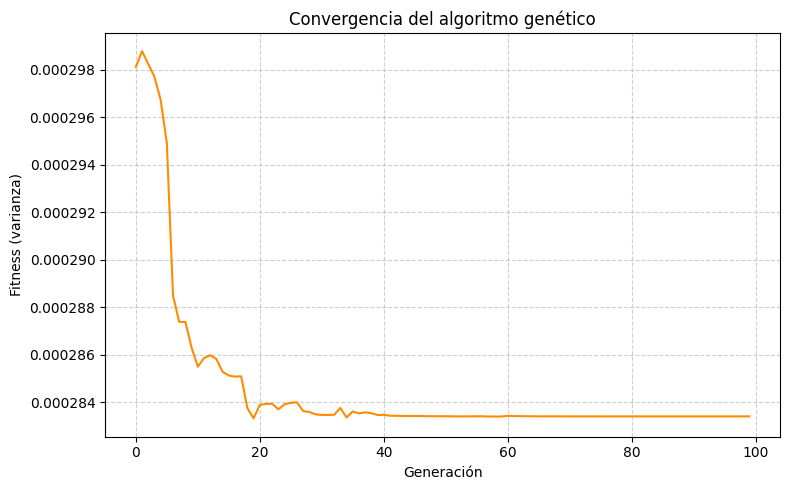

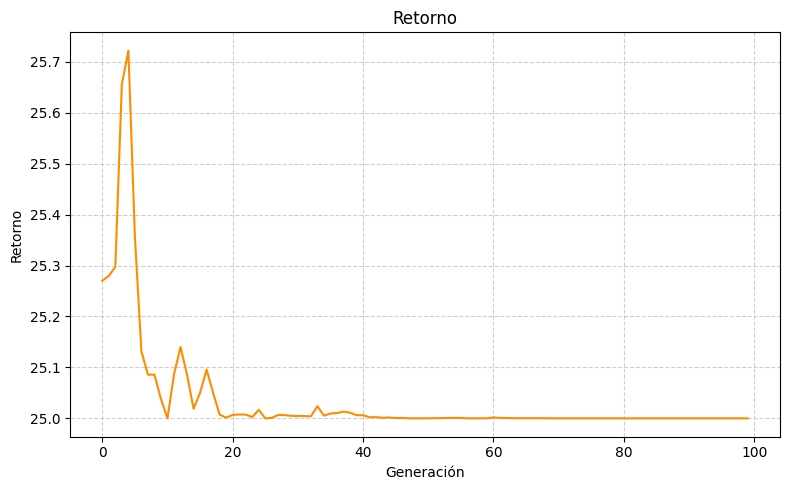

In [6]:
activos = ["AAPL","META","MSFT","SPY","SSO"]
activos = sorted(activos)

data = yf.download(activos, start='2020-01-01', end='2025-06-01', auto_adjust=True)['Close']
data = data[sorted(data.columns)]
returns = data.pct_change().dropna()
mean_returns = returns.mean()
cov_matrix = returns.cov()
# -------------------------------
# 2. Configuración del algoritmo genético
# -------------------------------
tamaño_poblacion = 50
generaciones = 100
tasa_mutacion = 0.1
tasa_cruce = 0.9

retorno_anual = 0.25
retorno_diario = (1 + retorno_anual) ** (1 / 252) - 1
n_activos = len(activos)

# -------------------------------
# 3. Funciones del algoritmo
# -------------------------------
def generar_individuos():
    individuo = np.random.dirichlet(np.ones(n_activos), size=1)[0]
    return individuo

def portfolio_performance(individuo):
    ret = np.dot(individuo, mean_returns)
    var = np.dot(individuo.T, np.dot(cov_matrix, individuo))

    return ret, var

def fitness(individuo):
    ret, var = portfolio_performance(individuo)
    if (retorno_diario - ret)>0:
      var = var + (retorno_diario - ret)*1000
    return var

def cruza(progenitor1, progenitor2, tasa_cruce):
    if random.random() < tasa_cruce:
        punto_cruce = random.randint(1, len(progenitor1) - 1)
        descendiente1 = np.concatenate((progenitor1[:punto_cruce], progenitor2[punto_cruce:]))
        descendiente2 = np.concatenate((progenitor2[:punto_cruce], progenitor1[punto_cruce:]))
        descendiente1 = np.clip(descendiente1, 0.02, 1)
        descendiente1 /= np.sum(descendiente1)
        descendiente2 = np.clip(descendiente2, 0.02, 1)
        descendiente2 /= np.sum(descendiente2)
    else:
        descendiente1, descendiente2 = progenitor1.copy(), progenitor2.copy()
    return descendiente1, descendiente2

def mutacion(descendiente, tasa_mutacion):
    for i in range(len(descendiente)):
        if random.random() < tasa_mutacion:
            descendiente[i] += np.random.normal(0, 0.1)

    descendiente = np.clip(descendiente, 0.02, 1)
    descendiente /= np.sum(descendiente)
    return descendiente


def seleccion_torneo(poblacion, tamanio_torneo=3):
    progenitores = []
    for _ in range(len(poblacion)):
        candidatos = random.sample(poblacion, tamanio_torneo)
        progenitor = min(candidatos, key=fitness)  # se selecciona el mejor individuo del torneo
        progenitores.append(progenitor)
    return progenitores
# -------------------------------
# 4. Ejecutar el algoritmo genético
# -------------------------------
def algoritmo(tamaño_poblacion,generaciones,tasa_mutacion,tasa_cruce):

  poblacion = [generar_individuos() for _ in range(tamaño_poblacion)]
  fitness_historico = []
  ret_historico = []
  pesos_por_generacion = []
  for gen in range(generaciones):
      progenitores = seleccion_torneo(poblacion)
      descendientes = []
      for i in range(0, len(progenitores), 2):
          descendiente1, descendiente2 = cruza(progenitores[i], progenitores[i + 1], tasa_cruce)
          descendientes.append(descendiente1)
          descendientes.append(descendiente2)


      #  -----------------------------------------------------------------
      # Mutacion

      descendientes_mutados = []
      for descendiente in descendientes:
          descendientes_mutados.append(mutacion(descendiente, tasa_mutacion))

      # se reemplaza la poblacion con los descendientes mutados
      poblacion = descendientes_mutados

      # se muestra el mejor individuo de la generacion

      mejor_individuo = min(poblacion, key=fitness)  # Buscar el mínimo para la aptitud
      fitness_historico.append(fitness(mejor_individuo))
      r,v = portfolio_performance(mejor_individuo)
      ret_historico.append(((1 + r) ** 252 - 1)*100)
      pesos_por_generacion.append(mejor_individuo.copy())
  return mejor_individuo, fitness_historico, ret_historico, pesos_por_generacion
# -------------------------------
# 5. Resultados finales
# -------------------------------
mejor_individuo, fitness_historico, ret_historico, pesos_por_generacion = algoritmo(tamaño_poblacion,generaciones,tasa_mutacion,tasa_cruce)
mejor_retorno_diario, mejor_varianza = portfolio_performance(mejor_individuo)

mejor_retorno_anual = (1 + mejor_retorno_diario) ** 252 - 1
desviacion_s = (np.sqrt(mejor_varianza) * np.sqrt(252))


print("Asignación óptima:")
for activo, porc in zip(activos, mejor_individuo):
    print(f"{activo}: {porc:.2%}")

print(f"\nRetorno esperado anual: {mejor_retorno_anual:.2%}")
print(f"Desviación estándar anual: {desviacion_s:.2%}")

# -------------------------------
# 6. Gráficos
# -------------------------------
def plot_portfolio(porc, labels):
    plt.figure(figsize=(8, 6))
    plt.bar(labels, porc, color='skyblue')
    plt.title("Asignación óptima del portafolio")
    plt.ylabel("Peso (%)")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_convergencia(valores):
    plt.figure(figsize=(8, 5))
    plt.plot(valores, color='darkorange')
    plt.title("Convergencia del algoritmo genético")
    plt.xlabel("Generación")
    plt.ylabel("Fitness (varianza)")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_retorno(valores):
    plt.figure(figsize=(8, 5))
    plt.plot(valores, color='darkorange')
    plt.title("Retorno")
    plt.xlabel("Generación")
    plt.ylabel("Retorno")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_portfolio(mejor_individuo, activos)
plot_convergencia(fitness_historico)
plot_retorno(ret_historico)

In [ ]:
tamaño_poblacion = 50
generaciones = 50
tasa_mutacion = 0.1
tasa_cruce = 0.8
n_ejecuciones = 20
fitness_resultados = []

for _ in range(n_ejecuciones):
   mejor_individuo, fitness_historico, ret_historico, pesos_por_generacion = algoritmo(tamaño_poblacion,generaciones,tasa_mutacion,tasa_cruce)
   r,v = portfolio_performance(mejor_individuo)
   s = (np.sqrt(v) * np.sqrt(252))*100
   fitness_resultados.append(s)

In [ ]:
tamaño_poblacion = 50
generaciones = 50
tasa_mutacion = 0.05
tasa_cruce = 0.8
n_ejecuciones = 20
fitness_resultados2 = []

for _ in range(n_ejecuciones):
   mejor_individuo, fitness_historico, ret_historico, pesos_por_generacion = algoritmo(tamaño_poblacion,generaciones,tasa_mutacion,tasa_cruce)
   r,v = portfolio_performance(mejor_individuo)
   s = (np.sqrt(v) * np.sqrt(252))*100
   fitness_resultados2.append(s)

In [ ]:
tamaño_poblacion = 50
generaciones = 50
tasa_mutacion = 0.1
tasa_cruce = 0.9
n_ejecuciones = 20
fitness_resultados3 = []

for _ in range(n_ejecuciones):
   mejor_individuo, fitness_historico, ret_historico, pesos_por_generacion = algoritmo(tamaño_poblacion,generaciones,tasa_mutacion,tasa_cruce)
   r,v = portfolio_performance(mejor_individuo)
   s = (np.sqrt(v) * np.sqrt(252))*100
   fitness_resultados3.append(s)

<ipython-input-43-5f304c8b2a9a>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Métrica', y='std', data=df, palette='Set2')


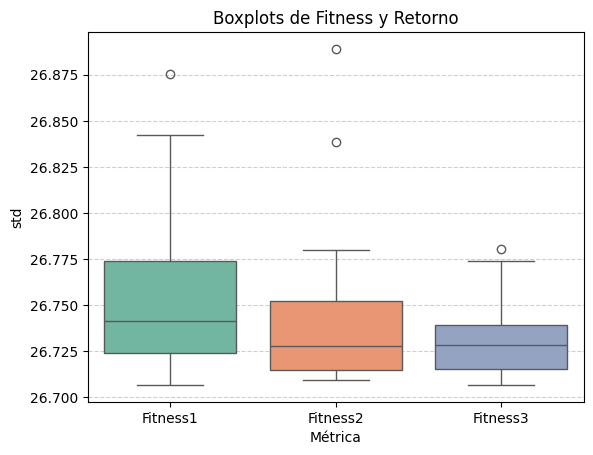

In [ ]:
import seaborn as sns
import pandas as pd
df = pd.DataFrame({
    'std': fitness_resultados + fitness_resultados2 + fitness_resultados3 ,
    'Métrica': ['Fitness1'] * len(fitness_resultados) + ['Fitness2'] * len(fitness_resultados2) + ['Fitness3'] * len(fitness_resultados3)
})

# Graficar
sns.boxplot(x='Métrica', y='std', data=df, palette='Set2')
plt.title("Boxplots de Fitness y Retorno")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()